In [1]:
# Importing libraries
import numpy as np
import astropy
from astropy.io import fits
import healpy as hp
import pandas as pd
import math
import scipy
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
NSIDE=2048
Nvals=12*NSIDE**2

pi=math.pi

In [2]:
# Reading maps
nilc_ymap = hp.read_map('COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00.fits')
nilc_stddevmap = hp.read_map('COM_CompMap_Compton-SZMap-nilc-stddev_2048_R2.00.fits')

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/maamari/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:367: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


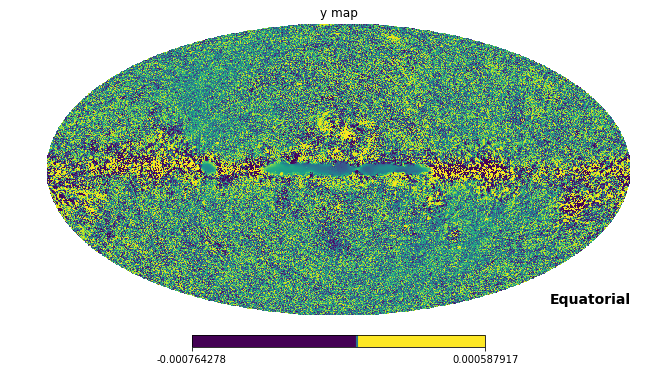

In [3]:
# Plot y map
hp.mollview(nilc_ymap,coord=['C'],norm='hist',title='y map')

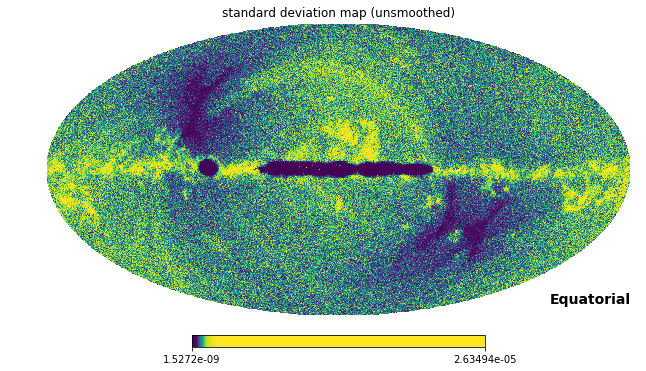

In [4]:
# Plot standard deviation map
hp.mollview(nilc_stddevmap,coord=['C'],norm='hist',title='standard deviation map (unsmoothed)')

In [5]:
# Smooth noise map by 1 degree
# The essential difference between Burenin and this, is that he uses
# a 1degree radius median filter for smoothing (not available on healpy)
stddev_smoothed = hp.smoothing(nilc_stddevmap,fwhm=np.radians(1.))

Sigma is 25.479654 arcmin (0.007412 rad) 
-> fwhm is 60.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


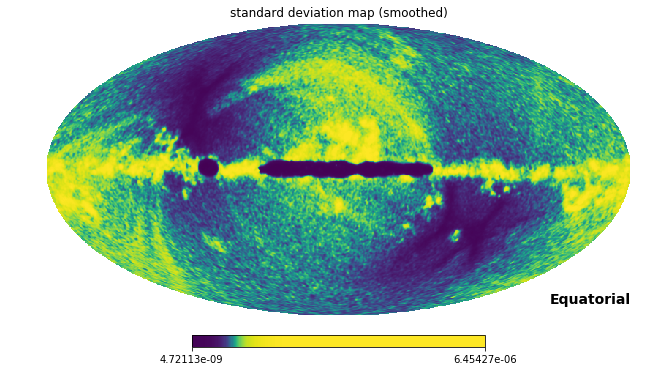

In [6]:
# Plot smoothed standard deviation map
hp.mollview(stddev_smoothed,coord=['C'],norm='hist',title='standard deviation map (smoothed)')

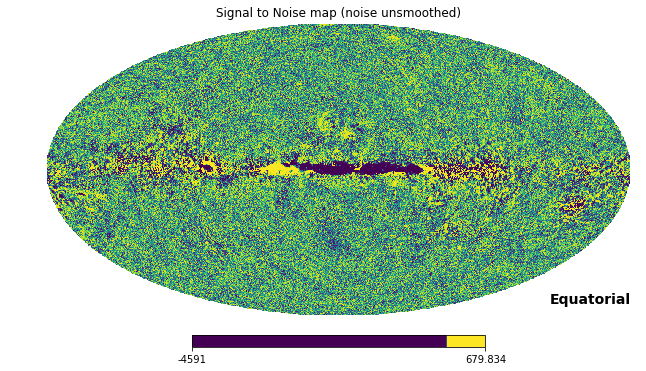

In [7]:
# Calculate signal over noise (unsmoothed) and plot the map
sn_unsmoothed_n = nilc_ymap/nilc_stddevmap
hp.mollview(sn_unsmoothed_n,coord=['C'],norm='hist',title='Signal to Noise map (noise unsmoothed)')

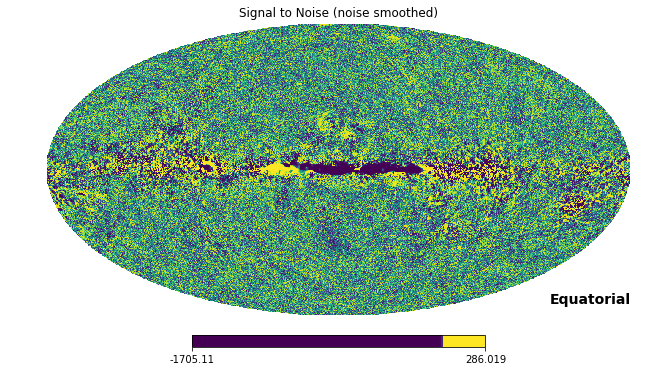

In [8]:
# Calculate signal over noise (smoothed) and plot the map
sn_smoothed_n = nilc_ymap/stddev_smoothed
hp.mollview(sn_smoothed_n,coord=['C'],norm='hist',title='Signal to Noise (noise smoothed)')

In [9]:
# Smooth the sn_smoothed_n map by 1 degree
sn_smoothed_n_smoothed = hp.smoothing(sn_smoothed_n,fwhm=np.radians(1.))

Sigma is 25.479654 arcmin (0.007412 rad) 
-> fwhm is 60.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


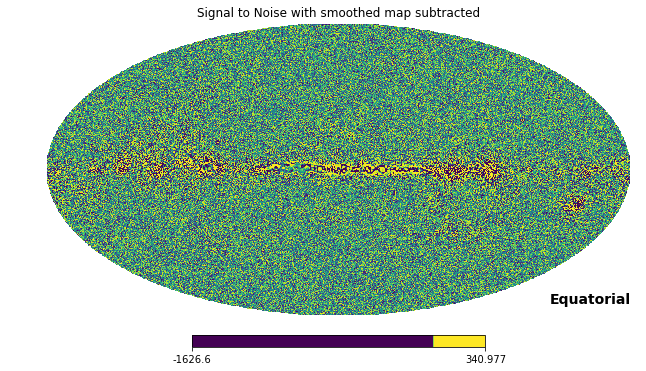

In [10]:
# Subtract the smoothed signal to noise map from the signal to noise map and plot
sn_result = sn_smoothed_n - sn_smoothed_n_smoothed
hp.mollview(sn_result,coord=['C'],norm='hist',title='Signal to Noise with smoothed map subtracted')

In [11]:
# Mask the sn_result array
mask=hp.read_map('maskplanckfullsz61.fits')
sn_masked = hp.ma(sn_result)
sn_masked.mask = np.logical_not(mask)
# By convention the mask is 0 where the data are masked, while numpy defines data masked when 
# the mask is True, so it is necessary to flip the mask.

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


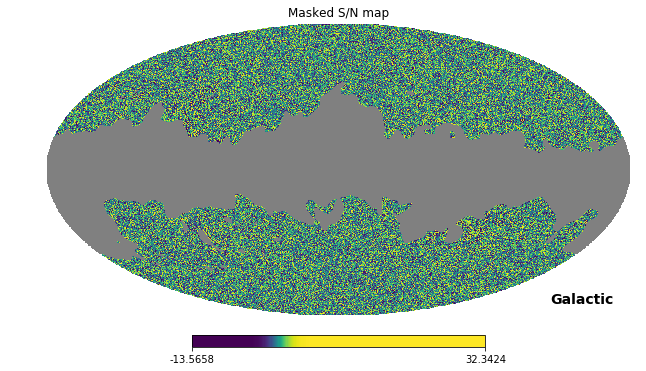

In [12]:
# Plot the masked array
hp.mollview(sn_masked.filled(),norm='hist',coord=['G'],title='Masked S/N map')

/home/maamari/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


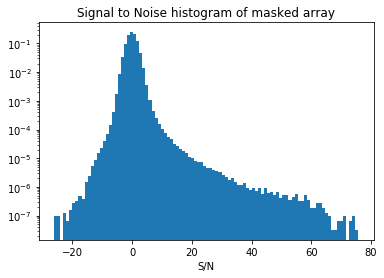

In [13]:
# Plot a histogram of the Signal to Noise masked map
# weights = np.ones_like(sn_masked.compressed())/len(sn_masked.compressed())
plt.hist(sn_masked.compressed(),bins=100,normed=True);
# plt.xlim((-20,20))
plt.yscale('log');
plt.xlabel('S/N');
plt.title('Signal to Noise histogram of masked array');

In [14]:
# No of pixels in the masked array with signal to noise >4.5
len(sn_masked[sn_masked>4.5])

1042744

In [15]:
stats.describe(sn_result)

DescribeResult(nobs=50331648, minmax=(-4947.534672832913, 4355.814902177516), mean=-6.661566337713163e-09, variance=28.60192622369359, skewness=-71.01532660339146, kurtosis=142121.86527726456)

In [16]:
stats.describe(sn_masked.compressed())

DescribeResult(nobs=30798613, minmax=(-26.148586240586305, 75.81991440596212), mean=0.0070465718542427995, variance=2.8633602973103818, skewness=0.9407763799131967, kurtosis=19.427286182824442)

In [17]:
# Fill masked vals in sn_masked with mean
sn_masked_filled = sn_masked.filled(0)

In [18]:
# Define functions to convert dec and ra to pixel vals and vice versa
def DeclRaToIndex(decl,RA):
    return hp.ang2pix(NSIDE,np.deg2rad(90.0-decl),np.deg2rad(RA),lonlat=False,nest=False)
# Define a function to convert index to dec, ra
def IndexToDeclRa(index):
    theta,phi=hp.pix2ang(NSIDE,index,lonlat=False,nest=False)
    return -np.degrees(theta-pi/2.),np.degrees(pi*2.-phi)
def DeclRaToIndex_8neighbors(decl,RA):
    return hp.get_all_neighbours(NSIDE,np.radians(90.0-decl),np.radians(360.0-RA),lonlat=False,nest=False)

In [19]:
# Load the AMF DR9 main catalog
amfdr9 = np.genfromtxt('dr9_main_catalog.dat', dtype=float)
amfdr9_ra = pd.Series(amfdr9[:,3],name='RA')
amfdr9_dec = pd.Series(amfdr9[:,4],name='Dec')
df_amf = pd.concat([amfdr9_dec,amfdr9_ra],axis=1)
df_amf.head()

Dec        RA
0  20.7465   23.9128
1  32.1398  260.6324
2  -1.3356  197.8796
3  46.6917  250.1485
4  21.0378  346.3402

In [20]:
# Get nearest 8 neighbours pixel values for amf dr9 cluster centers
# Then convert the array to a 1d array of pixel vals
amf_pix_8neighbours=DeclRaToIndex_8neighbors(df_amf['Dec'],df_amf['RA'])
amf_pix_8neighbours = np.reshape(amf_pix_8neighbours,(371832,)) #371832 = 46479*8

In [21]:
# Get sn values for amf dr9 pixels
amf_sn_arr = np.zeros(Nvals) #Fill an array with as many zeros as vals in the sn map (Nvals=50331648)
for i in amf_pix_8neighbours:
    amf_sn_arr[i] = sn_masked_filled[i]
    

In [22]:
# Descriptive statistics of the resultant array
stats.describe(amf_sn_arr)

DescribeResult(nobs=50331648, minmax=(-13.598189883556067, 15.872364875258146), mean=5.877762157697014e-05, variance=0.008308078567707737, skewness=3.062451494099554, kurtosis=1387.5782593787205)

In [23]:
# Number of pixels with sn vals > 4.5
len(amf_sn_arr[amf_sn_arr!=0])

152006

/home/maamari/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


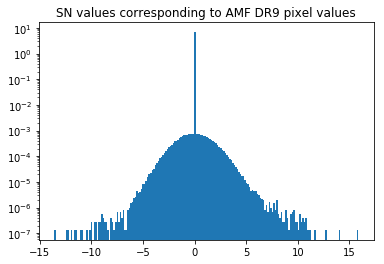

In [24]:
# Histogram of the sn values corresponding to amf dr9 values
plt.hist(amf_sn_arr,bins=200,normed=True);
plt.yscale('log');
plt.title('SN values corresponding to AMF DR9 pixel values');
# Note: The sharp peak is because we have filled in the masked values with the mean of the original sample
# which was ~0.07

In [25]:
# Create a dataframe with just the rich (>50) clusters of AMF DR9
# Total such clusters
len(amfdr9[amfdr9[:,7]>50])

2761

In [26]:
amfrichcut = amfdr9[amfdr9[:,7]>50]
amfrichcut_ra = pd.Series(amfrichcut[:,3],name='RA')
amfrichcut_dec = pd.Series(amfrichcut[:,4],name='Dec')
df_amfrichcut = pd.concat([amfrichcut_dec,amfrichcut_ra],axis=1)
df_amfrichcut.head()

Dec        RA
0  20.7465   23.9128
1  32.1398  260.6324
2  -1.3356  197.8796
3  46.6917  250.1485
4  21.0378  346.3402

In [27]:
# Get nearest 8 neighbours pixel values for amf dr9 cluster centers for richest clusters (>50)
# Then convert the array to a 1d array of pixel vals
amfgt50_pix_8neighbours=DeclRaToIndex_8neighbors(df_amfrichcut['Dec'],df_amfrichcut['RA'])
amfgt50_pix_8neighbours = np.reshape(amfgt50_pix_8neighbours,(22088,)) #22088 = 2761*8

In [28]:
amfgt50_sn_arr = np.zeros(Nvals) #Fill an array with as many zeros as vals in the sn map (Nvals=50331648)
for i in amfgt50_pix_8neighbours:
    amfgt50_sn_arr[i] = sn_masked_filled[i]
    

In [29]:
stats.describe(amfgt50_sn_arr)

DescribeResult(nobs=50331648, minmax=(-6.426567077599183, 10.146127661838115), mean=6.294835191098475e-06, variance=0.00045850494418335936, skewness=28.571312034514225, kurtosis=25954.97288999839)

/home/maamari/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


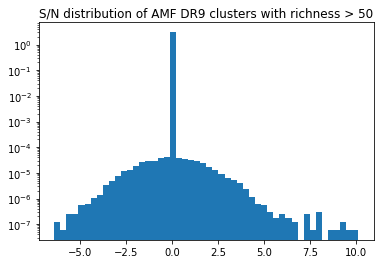

In [30]:
# S/N distribution of these pixels, should be quite high since these are rich clusters
plt.hist(amfgt50_sn_arr,bins=50,normed=True);
plt.yscale('log');
plt.title('S/N distribution of AMF DR9 clusters with richness > 50');
#

In [ ]:
# Load the redMaPPer catalog
red = np.loadtxt('redmapper2_v2.dat')
red_ra = pd.Series(red[:,1],name='RA')
red_dec = pd.Series(red[:,2],name='Dec')
df_red = pd.concat([red_dec,red_ra],axis=1)
df_red.head()

In [ ]:
# Get nearest 8 neighbours pixel values for redmapper cluster centers
# Then convert the array to a 1d array of pixel vals
red_pix_8neighbours=DeclRaToIndex_8neighbors(df_red['Dec'],df_red['RA'])
red_pix_8neighbours = np.reshape(red_pix_8neighbours,(210800,)) #210800 = 26350*8

In [ ]:
red_sn_arr = np.zeros(Nvals) #Fill an array with as many zeros as vals in the sn map (Nvals=50331648)
for i in red_pix_8neighbours:
    red_sn_arr[i] = sn_masked_filled[i]

In [ ]:
stats.describe(red_sn_arr)

In [ ]:
# Number of pixels with sn vals > 4.5
len(red_sn_arr[red_sn_arr>4.5])

In [ ]:
# Histogram of the sn values corresponding to redmapper values
plt.hist(red_sn_arr,bins=200,normed=True);
plt.yscale('log');
plt.title('SN values corresponding to redMaPPer pixel values');

In [42]:
# Load the Burenin Planck extended catalog
bur = np.loadtxt('planck_extended_burenin.dat')
bur_ra = pd.Series(bur[:,1],name='RA')
bur_dec = pd.Series(bur[:,2],name='Dec')
df_bur = pd.concat([bur_dec,bur_ra],axis=1)
df_bur.head()

Dec      RA
0  29.1144  0.2000
1  21.5636  0.2958
2  -0.0147  0.3500
3  12.0578  0.5042
4  -1.0683  0.7042

In [43]:
# Get nearest 8 neighbours pixel values for burenin cluster centers
# Then convert the array to a 1d array of pixel vals
bur_pix_8neighbours=DeclRaToIndex_8neighbors(df_bur['Dec'],df_bur['RA'])
bur_pix_8neighbours = np.reshape(bur_pix_8neighbours,(23712,)) #23712 = 2964*8

In [44]:
bur_sn_arr = np.zeros(Nvals) #Fill an array with as many zeros as vals in the sn map (Nvals=50331648)
for i in bur_pix_8neighbours:
    bur_sn_arr[i] = sn_masked_filled[i]

In [45]:
stats.describe(bur_sn_arr)

DescribeResult(nobs=50331648, minmax=(-6.355842702313861, 17.085018743498612), mean=2.9065905614626103e-05, variance=0.0007189885248244202, skewness=51.10002005770999, kurtosis=27363.805314453082)

In [46]:
# Number of pixels with sn vals > 4.5
len(bur_sn_arr[bur_sn_arr>4.5])

95

/home/maamari/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


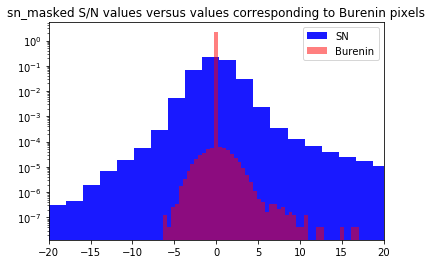

In [47]:
# Plot of sn_masked S/N values versus values corresponding to Burenin pixels
plt.hist(sn_masked.compressed(),bins=50,color='b',label='SN',alpha=0.9,normed=True)
plt.hist(bur_sn_arr,bins=50,color='r',alpha=0.5,label='Burenin',normed=True)
plt.xlim((-20,20))
plt.legend(loc='best')
plt.yscale('log')
plt.title('sn_masked S/N values versus values corresponding to Burenin pixels');
# Note: The sharp peak is because we have filled in the masked values with the mean of the original sample
# which was ~0.07

/home/maamari/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


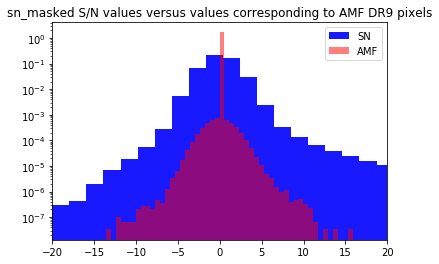

In [48]:
# Plot of sn_masked S/N values versus values corresponding to AMF DR9 pixels
plt.hist(sn_masked.compressed(),bins=50,color='b',label='SN',alpha=0.9,normed=True)
plt.hist(amf_sn_arr,bins=50,color='r',alpha=0.5,label='AMF',normed=True)
plt.xlim((-20,20))
plt.legend(loc='best')
plt.yscale('log')
plt.title('sn_masked S/N values versus values corresponding to AMF DR9 pixels');
# Note: The sharp peak is because we have filled in the masked values with the mean of the original sample
# which was ~0.07

/home/maamari/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


NameError: name 'red_sn_arr' is not defined

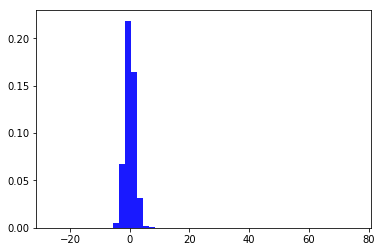

In [49]:
# Plot of sn_masked S/N values versus values corresponding to redMaPPer pixels
plt.hist(sn_masked.compressed(),bins=50,color='b',label='SN',alpha=0.9,normed=True)
plt.hist(red_sn_arr,bins=50,color='r',alpha=0.5,label='Red',normed=True)
plt.xlim((-20,20))
plt.legend(loc='best')
plt.yscale('log')
plt.title('sn_masked S/N values versus values corresponding to redMaPPer pixels');
# Note: The sharp peak is because we have filled in the masked values with the mean of the original sample
# which was ~0.07

/home/maamari/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


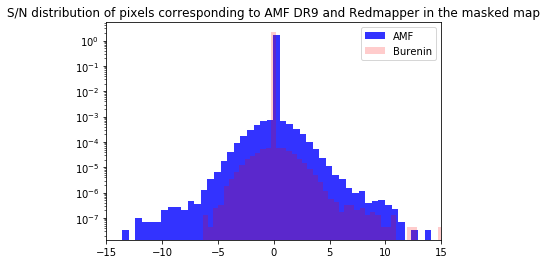

In [64]:
# Plot of AMF DR9, redMaPPer and Burenin S/N values in the masked map (corresponding to pixel vals)
plt.hist(amf_sn_arr,bins=50,alpha=0.8,color='b',label='AMF',normed=True);
# plt.hist(red_sn_arr,bins=50,alpha=0.5,color='r',label='Red',normed=True);
plt.hist(bur_sn_arr,bins=50,alpha=0.2,color='r',label='Burenin',normed=True)
plt.xlim((-15,15))
plt.legend(loc='best')
plt.yscale('log')
plt.title('S/N distribution of pixels corresponding to AMF DR9 and Redmapper in the masked map');
# Note: The sharp peak is because we have filled in the masked values with the mean of the original sample
# which was ~0.07

In [63]:
# Create a dataframe with just the rich (>80) clusters of red
# Total such clusters
len(red[red[:,4]>80])

NameError: name 'red' is not defined

In [ ]:
redrichcut = red[red[:,4]>80]
redrichcut_ra = pd.Series(redrichcut[:,1],name='RA')
redrichcut_dec = pd.Series(redrichcut[:,2],name='Dec')
df_redrichcut = pd.concat([redrichcut_dec,redrichcut_ra],axis=1)
df_redrichcut.head()

In [ ]:
# Get nearest 8 neighbours pixel values for redmapper cluster centers for richest clusters (>80)
# Then convert the array to a 1d array of pixel vals
redgt80_pix_8neighbours=DeclRaToIndex_8neighbors(df_redrichcut['Dec'],df_redrichcut['RA'])
redgt80_pix_8neighbours = np.reshape(redgt80_pix_8neighbours,(8776,)) #8776 = 1097*8

In [ ]:
redgt80_sn_arr = np.zeros(Nvals) #Fill an array with as many zeros as vals in the sn map (Nvals=50331648)
for i in redgt80_pix_8neighbours:
    redgt80_sn_arr[i] = sn_masked_filled[i]

In [ ]:
stats.describe(redgt80_sn_arr)

In [ ]:
# S/N distribution of these pixels, should be quite high since these are rich clusters
plt.hist(redgt80_sn_arr,bins=50,normed=True);
plt.yscale('log');
plt.title('S/N distribution of redMaPPer clusters with richness > 80');
# Note: The sharp peak is because we have filled in the masked values with the mean of the original sample
# which was ~0.07

In [ ]:
# Now trying the above analysis using just the signal over noise (unsmoothed map) and amfdr9
# No smoothing, no masking
amf_sn_basic_arr = np.zeros(Nvals) #Fill an array with as many zeros as vals in the sn map (Nvals=50331648)
for i in amf_pix_8neighbours:
    amf_sn_basic_arr[i] = sn_unsmoothed_n[i]


In [ ]:
# Histogram of the sn values (unmasked, unsmoothed) corresponding to amf dr9 values
plt.hist(amf_sn_basic_arr,bins=20,normed=True);
plt.yscale('log');
plt.title('SN (unsmoothed,unmasked) values corresponding to AMF DR9 pixel values');

In [ ]:
# No. of values with sn>4.5
len(amf_sn_basic_arr[amf_sn_basic_arr>4.5])

In [ ]:
# Now trying the above analysis using just the signal over noise (unsmoothed map) and redmapper
# No smoothing, no masking
red_sn_basic_arr = np.zeros(Nvals) #Fill an array with as many zeros as vals in the sn map (Nvals=50331648)
for i in red_pix_8neighbours:
    red_sn_basic_arr[i] = sn_unsmoothed_n[i]

In [ ]:
# Histogram of the sn values (unmasked, unsmoothed) corresponding to redmapper values
plt.hist(red_sn_basic_arr,bins=30);
plt.yscale('log');
plt.title('SN (unsmoothed,unmasked) values corresponding to AMF DR9 pixel values');

In [ ]:
# No. of values with sn>4.5
len(red_sn_basic_arr[red_sn_basic_arr>4.5])

In [ ]:
# Plotting the 3 catalog maps, AMF DR9, redMaPPer (both of which overlap the sdss area) and Burenin
amf_arr=np.zeros(Nvals)
for i in amf_pix_8neighbours:
    amf_arr[i]=1
#Fill all vals where there is a pixel corresponding to a cluster center with 1
red_arr=np.zeros(Nvals)
for i in red_pix_8neighbours:
    red_arr[i]=1
    
bur_arr=np.zeros(Nvals)
for i in bur_pix_8neighbours:
    bur_arr[i]=1      

---

In [ ]:
cmap=cm.autumn_r
cmap.set_over(cmap(1.0))
cmap.set_under('w')
cmap.set_bad('gray')
hp.mollview(amf_arr,coord=['G'],cmap=cmap,title='AMF DR9 pixel vals')

In [ ]:
cmap=cm.bwr
cmap.set_over(cmap(1.0))
cmap.set_under('w')
cmap.set_bad('gray')
hp.mollview(amf_sn_arr,coord=['G'],cmap=cmap,title='AMF DR9 SN masked pixel vals')

In [ ]:
cmap=cm.autumn_r
cmap.set_over(cmap(1.0))
cmap.set_under('w')
cmap.set_bad('gray')
hp.mollview(red_arr,coord=['G'],cmap=cmap,title='redMaPPer pixel vals')

In [ ]:
cmap=cm.bwr
cmap.set_over(cmap(1.0))
cmap.set_under('w')
cmap.set_bad('gray')
hp.mollview(red_sn_arr,coord=['G'],cmap=cmap,title='redMaPPer SN masked pixel vals')

In [ ]:
cmap=cm.autumn_r
cmap.set_over(cmap(1.0))
cmap.set_under('w')
cmap.set_bad('gray')
hp.mollview(bur_arr,coord=['C'],cmap=cmap,title='Burenin pixel vals')

In [ ]:
cmap=cm.bwr
cmap.set_over(cmap(1.0))
cmap.set_under('w')
cmap.set_bad('gray')
hp.mollview(bur_sn_arr,coord=['C'],cmap=cmap,title='Burenin SN masked pixel vals')

In [ ]:
# The 1st Burenin cluster has RA, DEc = 0.20375, 29.11444444
# with an S/N of 4.58
# Import this check pixel s/n value from our masked map
test_pix = DeclRaToIndex(29.11444,0.20375)
test_pix

In [ ]:
DeclRaToIndex(-32.465065,109.819368)

In [ ]:
sn_masked[test_pix]

In [ ]:
sn_masked[38672835] #Maybe?

In [ ]:
# So pixel value is masked..
# Checking sn_result array

In [ ]:
sn_result[38676029] #Definitely wrong


In [ ]:

sn_unsmoothed_n[38676029]


In [ ]:
sn_smoothed_n[test_pix]


In [ ]:
# 2nd Burenin cluster ra, dec = 0.2958    21.5636, S/N = 7.7
test_pix2 = DeclRaToIndex(21.5636,0.2958)



In [ ]:
DeclRaToIndex(-39.813384,107.662059)

In [ ]:
sn_masked[41277842] #maybe?

In [ ]:
sn_masked[test_pix2]



In [ ]:
sn_result[test_pix2]



In [ ]:
sn_unsmoothed_n[test_pix2]



In [ ]:
sn_smoothed_n[test_pix2]



In [ ]:
# 3rd Burenin cluster, ra, dec = 0.3500    -0.0147, S/N = 4.55
test_pix3 = DeclRaToIndex(-0.0147,0.3500)



In [ ]:
DeclRaToIndex(-60.339963,96.974162)

In [ ]:
sn_masked[47033151]

In [ ]:

sn_masked[test_pix3]



In [ ]:
sn_result[test_pix3]



In [ ]:
sn_unsmoothed_n[test_pix3]



In [ ]:
sn_smoothed_n[test_pix3]



In [ ]:
# 4th cluster Burenin RA Dec = 0.5042    12.0578 SN = 9.52
test_pix4 = DeclRaToIndex(12.0578,0.5042)


In [ ]:
DeclRaToIndex(-49.020180,104.324467)

In [ ]:
sn_masked[44163099]

In [ ]:
sn_masked[test_pix4]

In [ ]:
sn_result[test_pix4]

In [ ]:
sn_unsmoothed_n[test_pix4]

In [ ]:
sn_smoothed_n[test_pix4]

In [ ]:
# 5th cluster Burenin RA Dec = 0.7042    -1.0683, SN = 4.99
test_pix5 = DeclRaToIndex(-1.0683,0.7042)

In [ ]:
DeclRaToIndex(-61.448190,96.797885)

In [ ]:
sn_masked[47270166]

In [ ]:
sn_masked[test_pix5]

In [ ]:
sn_result[test_pix5]

In [ ]:
sn_smoothed_n[test_pix5]

In [ ]:
sn_unsmoothed_n[test_pix5]

In [ ]:
test_pix

In [ ]:
IndexToDeclRa(test_pix)